# Early Seizure Detection and Classification Using LSTM Autoencoder and SVM Algorithm



In [1]:

%matplotlib inline
import tensorflow as tf

import pandas as pd
import numpy as np


from tensorflow.keras import optimizers

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Flatten

from tensorflow.keras.layers import Reshape

from tensorflow.python.keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns



## Reading and preparing data

In [197]:
df = pd.read_csv("df_3.csv")
print(df.shape)
df.head(n=5)  # visualize the data.

(25856, 23)


,Fp1,Fp2,F3,F4,F7,F8,Fz,C3,C4,Cz,...,T6,P3,P4,Pz,O1,O2,ECG,Resp,Seizure,label
0,-5.184484,-7.168125,-7.168125,-8.999179,-6.100011,-0.301676,-3.048255,-1.217202,-3.048255,1.224202,...,-0.149088,-4.726721,1.681965,-5.947423,-0.149088,1.987141,-46.688358,1.987141,0,29
1,-4.879309,-7.320713,-6.862950,-9.609530,-6.557774,-1.217202,-3.658607,-1.369790,-3.506019,1.224202,...,-0.301676,-5.184484,2.444904,-6.100011,0.003500,2.139729,-44.552129,2.444904,0,29
2,-3.963782,-5.947423,-6.862950,-9.151766,-6.100011,-1.827553,-3.048255,-1.064614,-3.353431,0.613851,...,-0.912027,-4.574133,2.597492,-5.794835,0.156088,0.919027,-46.230595,2.750080,0,29
3,-3.811194,-4.574133,-6.862950,-8.388827,-5.642248,-0.912027,-1.827553,-0.912027,-2.590492,0.613851,...,-0.912027,-3.658607,1.987141,-5.337072,0.003500,-0.301676,-49.740113,3.055255,0,29
4,-4.421545,-5.794835,-7.015537,-8.083652,-6.100011,0.003500,-1.980141,-1.217202,-2.437904,1.071614,...,-0.454263,-3.811194,1.071614,-5.642248,0.003500,-0.912027,-52.028930,3.818194,0,29


In [198]:
df.columns

Index(['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz', 'C3', 'C4', 'Cz', 'T3',
       'T5', 'T4', 'T6', 'P3', 'P4', 'Pz', 'O1', 'O2', 'ECG', 'Resp',
       'Seizure', 'label'],
      dtype='object')

In [199]:
# Rename and drop column lable'
df.rename(columns={'Seizure': 'y'}, inplace=True)

# Drop 'Label' column
df.drop('label', axis=1, inplace=True)


# 
# Segment data and create a new array for y  

In [200]:
import pandas as pd
import numpy as np

# Segmentation 
segment_size = 256  # Number of samples per segment
num_segments = len(df) // segment_size

# Initialize an empty list to store mode values arrays
mode_values_list = []

# Iterate through segments
for segment_idx in range(num_segments):
    start_idx = segment_idx * segment_size
    end_idx = (segment_idx + 1) * segment_size
    
    # Extract 'y' values for the segment
    segment_y = df.iloc[start_idx:end_idx, -1]  # Assuming 'y' is the last column
    
    # Calculate mode of 'y' values for the segment
    segment_mode_y = segment_y.mode().values  # Mode values as an array
    
    # Append mode values to the list
    mode_values_list.append(segment_mode_y)

# Convert list of mode values arrays to a single NumPy array
mode_values_array = np.array(mode_values_list)

# Print the  shape
#print(mode_values_array)
print("Shape of mode_values_array:", mode_values_array.shape)


Shape of mode_values_array: (101, 1)


# Segment Dataset and Perform short-time Fourier transform (STFT)

In [201]:
import pandas as pd
import numpy as np
from scipy.signal import stft


df = pd.DataFrame(df, columns=['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7',
        'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'ECG', 'Resp', 'y'])


# Specify the columns to keep in the new DataFrame
#columns_to_keep = df.drop(columns=['y']).columns.tolist()  # This gets all column names from df

# Create a new DataFrame with selected columns
#df = df[columns_to_keep]  # This filters columns based on 'columns_to_keep'
#df = df[columns_to_keep]  # This filters columns based on 'columns_to_keep'

#df = pd.DataFrame(df, df.columns)

# Example segmentation 
segment_size = 256  # Number of samples per segment
num_segments = len(df) // segment_size

# Empty dictionary to store hierarchical segmented STFT features
hierarchical_stft_features = {}

# Parameters for STFT
fs = 256  # Sampling frequency (Hz)
nperseg = 256  # Window size for STFT
noverlap = nperseg // 2  # Overlap between windows

# Perform STFT for each segment
for segment_idx in range(num_segments):
    start_idx = segment_idx * segment_size
    end_idx = (segment_idx + 1) * segment_size
    
    # Extract EEG data for the segment
    segment_df = df.iloc[start_idx:end_idx, :-1]  # Exclude 'y' column
    
    # Perform STFT for each channel in the segment
    segment_stft_features = {}
    for channel in segment_df.columns:
        f, t, Zxx = stft(segment_df[channel], fs=fs, nperseg=nperseg, noverlap=noverlap)
        segment_stft_features[channel] = np.abs(Zxx)  # Store magnitude of STFT coefficients
    
    # Store segment's STFT features for each channel in the hierarchical dictionary
    for channel, stft_data in segment_stft_features.items():
        if channel not in hierarchical_stft_features:
            hierarchical_stft_features[channel] = {'STFT': []}
        hierarchical_stft_features[channel]['STFT'].append(stft_data)

# Convert lists to arrays in the hierarchical dictionary
for channel, data in hierarchical_stft_features.items():
    hierarchical_stft_features[channel]['STFT'] = np.array(data['STFT'])

# Print an example channel's shape for verification
example_channel = 'Fp1'
print(f"Shape of STFT features for channel '{example_channel}': {hierarchical_stft_features[example_channel]['STFT'].shape}")


Shape of STFT features for channel 'Fp1': (101, 129, 3)


# Structure STFT features for multiple channels into a  DataFrame

In [202]:
import pandas as pd


example_channel = df.columns.drop('y').tolist()  # Exclude 'y' column if it exists

df_list = []

for channel in example_channel:
    combined_df = pd.DataFrame()
    num_segments, num_rows, num_columns_per_segment = hierarchical_stft_features[channel]['STFT'].shape

    for segment_idx in range(num_segments):
        segment_stft = hierarchical_stft_features[channel]['STFT'][segment_idx]
        reshaped_stft = segment_stft.reshape(num_rows, num_columns_per_segment)
        segment_df = pd.DataFrame(reshaped_stft)
        combined_df = pd.concat([combined_df, segment_df], axis=1)

    combined_df.columns = [f'STFT_{segment_idx}_{col}' for segment_idx in range(num_segments) for col in range(num_columns_per_segment)]
    flattened_df = combined_df.stack().reset_index(drop=True).to_frame()
    flattened_df.columns = [f'{channel}_STFT']

    df_list.append(flattened_df)

df = pd.concat(df_list, axis=1)

# Print the shape of df
print(f"Shape of df: {df.shape}")



Shape of df: (39087, 21)


# Concatenate mode_values_array with df to create a new df

In [203]:
# Calculate the number of rows per segment based on mode_values_array shape
rows_per_segment = len(df) // mode_values_array.shape[0]

# Create a new column 'y' in df
df['y'] = np.repeat(mode_values_array.flatten(), rows_per_segment)

# Print the head of df to verify the 'y' values assignment
print(df.head())

# Print the shape of df for verification
print("Shape of df:", df.shape)


   Fp1_STFT  Fp2_STFT   F3_STFT   F4_STFT   C3_STFT   C4_STFT   P3_STFT  \
0  3.217461  4.202083  4.094418  4.795878  1.994908  2.904731  3.268426   
1  6.847504  8.669592  7.178796  9.362163  5.703732  5.932208  6.197351   
2  2.932566  3.869026  2.495601  4.041779  2.216141  2.821874  2.698482   
3  2.300968  3.666706  1.910468  3.710537  1.883648  2.825987  1.557251   
4  2.093362  5.825376  1.797594  5.663315  3.434284  4.168961  1.824197   

    P4_STFT   O1_STFT   O2_STFT  ...   T3_STFT   T4_STFT   T5_STFT   T6_STFT  \
0  0.978927  0.030872  1.110286  ...  3.653170  3.920618  3.374274  1.171225   
1  3.708961  0.039240  2.088158  ...  7.138183  7.644419  7.451330  3.797003   
2  0.962780  0.016315  0.035672  ...  2.362342  2.599552  3.344946  1.556244   
3  1.092572  0.045734  0.059016  ...  1.514484  1.688917  3.054244  1.701460   
4  3.216649  0.055312  0.086552  ...  2.008387  2.501957  4.236104  1.891511   

    Fz_STFT   Cz_STFT   Pz_STFT   ECG_STFT  Resp_STFT  y  
0  2.8612

check for sanity

In [204]:
# Check for NaN values
nan_values = df.isna()  # or df.isnull()

# Count NaN values and print
nan_count = nan_values.sum()
print("Number of NaN values in each column:")
print(nan_count)

Number of NaN values in each column:
Fp1_STFT     0
Fp2_STFT     0
F3_STFT      0
F4_STFT      0
C3_STFT      0
C4_STFT      0
P3_STFT      0
P4_STFT      0
O1_STFT      0
O2_STFT      0
F7_STFT      0
F8_STFT      0
T3_STFT      0
T4_STFT      0
T5_STFT      0
T6_STFT      0
Fz_STFT      0
Cz_STFT      0
Pz_STFT      0
ECG_STFT     0
Resp_STFT    0
y            0
dtype: int64


# Shift Data

In [205]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [206]:
'''
For example, shift the data by 2 steps s.

Test: Testing whether the shift happened correctly.
'''
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 2560 rows to do a 10 seconds ahead prediction.
df = curve_shift(df, shift_by = -2560)
#df = curve_shift(df, shift_by = -1280)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))  

Before shifting


,Fp1_STFT,Fp2_STFT,F3_STFT,F4_STFT,C3_STFT
1158,3.316483,2.986019,3.185042,2.992859,3.130355
1159,2.862744,3.163482,2.285179,3.808861,2.847600
1160,2.252689,2.014555,1.839583,1.936124,1.648935
1161,2.162566,2.424547,1.883753,2.266666,2.978130
1162,3.701118,4.254584,3.155334,4.188166,5.110062


After shifting


,y,Fp1_STFT,Fp2_STFT,F3_STFT,F4_STFT
1157,1.0,2.113592,2.343063,1.924724,2.073701
1158,1.0,3.316483,2.986019,3.185042,2.992859
1159,1.0,2.862744,3.163482,2.285179,3.808861
1160,1.0,2.252689,2.014555,1.839583,1.936124
7740,0.0,0.011235,0.065834,0.050344,0.060839


In [207]:
df.shape

(22059, 22)

Divide the data into train, valid, and test

In [67]:
from sklearn.model_selection import train_test_split

# First split into df_train and df_remaining
df_train, df_remaining = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)

# Specify the desired sizes for df_valid and df_test
valid_size = 0.5  # Example: 20% of the remaining data for validation
test_size = len(df_remaining) - int(valid_size * len(df_remaining))

# Split df_remaining into df_valid and df_test
df_valid, df_test = train_test_split(df_remaining, test_size=test_size, random_state=SEED)

# Print the sizes of each set for verification
#print(f"df_train size: {len(df_train)}")
#print(f"df_valid size: {len(df_valid)}")
#print(f"df_test size: {len(df_test)}")


In the autoencoder, we will be encoding only the negatively labeled data. That is, we will take the part of data for which y=0 and build an autoencoder. For that, we will divide the datasets as following.

In [68]:
df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]
df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_1_x = df_train_1.drop(['y'], axis=1)

df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)

df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

Standardize the data
It is usually better to use a standardized data (transformed to Gaussian, mean 0 and sd 1) for autoencoders.

In [69]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

# Model Trial 2c

In [70]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model

nb_epoch = 200
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1]  # num of predictor variables
encoding_dim = 64  # Increased encoding dimension
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim,))
# Encoder layers
encoder = Dense(encoding_dim*2, activation="relu")(input_layer)  # 1st encoder layer
encoder = Dense(encoding_dim, activation="relu")(encoder)         # 2nd encoder layer
encoder = Dense(hidden_dim, activation="relu")(encoder)           # 3rd encoder layer

# Additional hidden layers
hidden_layer1 = Dense(64, activation="relu")(encoder)             # 1st hidden layer
hidden_layer2 = Dense(32, activation="relu")(hidden_layer1)       # 2nd hidden layer

# Decoder layers
decoder = Dense(hidden_dim, activation="relu")(hidden_layer2)     # 1st decoder layer
decoder = Dense(encoding_dim, activation="relu")(decoder)         # 2nd decoder layer
decoder = Dense(encoding_dim*2, activation="relu")(decoder)        # 3rd decoder layer

output_layer = Dense(input_dim, activation="linear")(decoder)      # Output layer

# Build and compile the model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)         │ (None, 21)                    │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_9 (Dense)                    │ (None, 128)                   │       2,816 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_10 (Dense)                   │ (None, 64)                    │       8,256 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_11 (Dense)                   │ (None, 32)                    │       2,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_12 (Dense)                   │ (None, 64)                    │       2,112 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_13 (Dense)                   │ (None, 32)                    │       2,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_14 (Dense)                   │ (None, 32)                    │       1,056 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_15 (Dense)                   │ (None, 64)                    │       2,112 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_16 (Dense)                   │ (None, 128)                   │       8,320 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_17 (Dense)                   │ (None, 21)                    │       2,709 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 31,541 (123.21 KB)

 Trainable params: 31,541 (123.21 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier.keras",
                     save_best_only=True,
                     verbose=0,
                     save_weights_only=False,  # Make sure to save the entire model
                     monitor='val_loss',
                     mode='min')

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Epoch 1/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1818 - loss: 0.6543 - val_accuracy: 0.6272 - val_loss: 0.1495
Epoch 2/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6030 - loss: 0.1253 - val_accuracy: 0.6527 - val_loss: 0.0937
Epoch 3/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6553 - loss: 0.0806 - val_accuracy: 0.7136 - val_loss: 0.0681
Epoch 4/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6992 - loss: 0.0638 - val_accuracy: 0.7489 - val_loss: 0.0546
Epoch 5/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7228 - loss: 0.0538 - val_accuracy: 0.7500 - val_loss: 0.0494
Epoch 6/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7387 - loss: 0.0495 - val_accuracy: 0.7397 - val_loss: 0.0445
Epoch 7/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7438 - loss: 0.0416 - val_accuracy: 0.7891 - val_loss: 0.0374
Epoch 8/200
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7603 - loss: 0.0348 - val_acc

In [24]:
from keras.models import Model, load_model
autoencoder2 = load_model('autoencoder_classifier.keras')

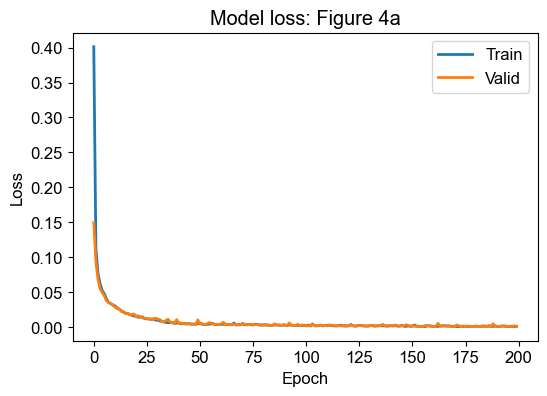

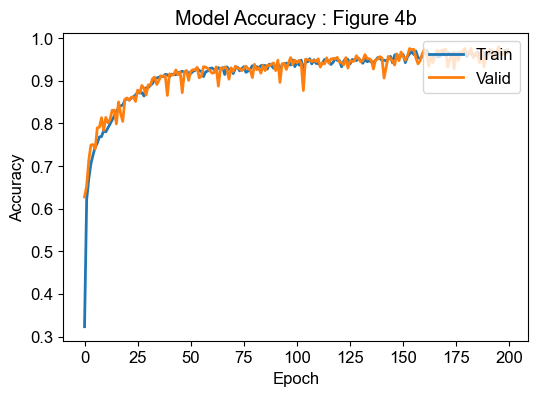

In [72]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss: Figure 4a')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
#model 2 had 0.493 acco and lsoo 0.09

plt.plot(history['accuracy'], linewidth=2, label='Train')
plt.plot(history['val_accuracy'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model Accuracy : Figure 4b')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
#model 2 had 0.493 acco and lsoo 0.09

Make predictions

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


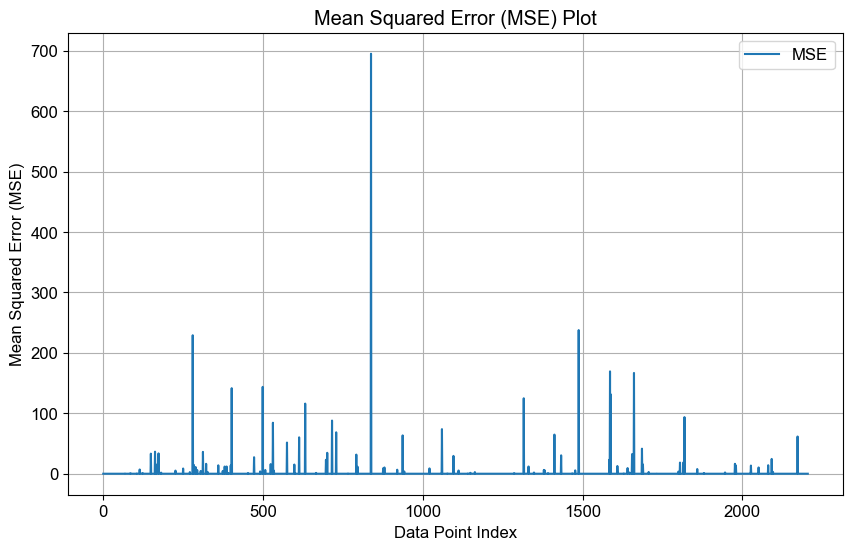

In [73]:
import matplotlib.pyplot as plt
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)

# Assuming 'mse' is already calculated
# Create an array of indices for x-axis
indices = np.arange(len(mse))

# Plotting MSE values
plt.figure(figsize=(10, 6))
plt.plot(indices, mse, label='MSE')
plt.xlabel('Data Point Index')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error (MSE) Plot')
plt.legend()
plt.grid(True)
plt.show()


In [74]:
import numpy as np

# Calculate squared error without computing the mean
squared_error = np.power(df_valid_x_rescaled - valid_x_predictions, 2)

# Print the first 6 values of squared error
#print(squared_error[:6])
print("Shape of the squared error array:", squared_error.shape)

Shape of the squared error array: (2206, 21)


In [75]:
error_valid = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['y']})
print(error_valid)


       Reconstruction_error  True_class
15650              0.000772         0.0
11016              0.002617         0.0
21625              0.000194         0.0
20519              0.000175         0.0
22589              0.000123         0.0
...                     ...         ...
21750              0.000251         0.0
20201              0.000214         0.0
38185              0.000138         0.0
37768              0.000109         0.0
18912              0.000187         0.0

[2206 rows x 2 columns]


The inferencing for seizure event prediction using an autoencoder is made by classifying the reconstruction errors as high or low. A high reconstruction error indicates the sample is anomalous to the normal process and, therefore, inferred as a rare event.

To determine the threshold of high vs low, boxplot statistics of the reconstruction error is determined for the positive and negative samples in the validation set

<Figure size 1000x600 with 0 Axes>

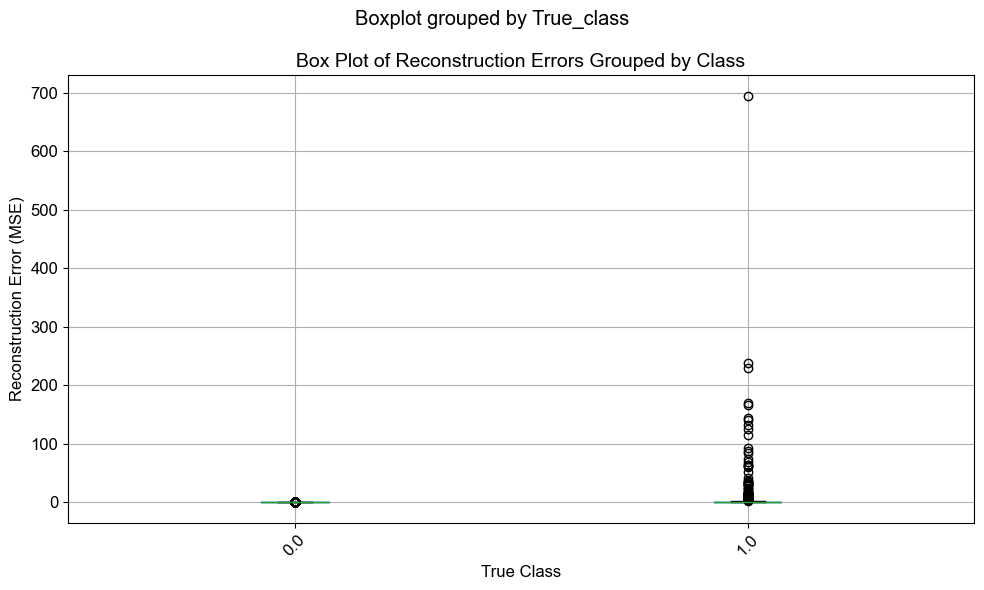

In [76]:
import matplotlib.pyplot as plt
import pandas as pd

error_valid = pd.DataFrame({'Reconstruction_error': mse, 'True_class': df_valid['y']})

# Set font parameters
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# Plotting the box plot
plt.figure(figsize=(10, 6))
error_valid.boxplot(column='Reconstruction_error', by='True_class', figsize=(10, 6))
plt.title('Box Plot of Reconstruction Errors Grouped by Class', fontsize=14)
plt.xlabel('True Class', fontsize=12)
plt.ylabel('Reconstruction Error (MSE)', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


In [79]:
import pandas as pd

# Example DataFrame with 'Reconstruction_error' and 'True_class'
error_valid = pd.DataFrame({'Reconstruction_error': mse, 'True_class': df_valid['y']})

# Compute errors_valid0 (MSE when True_class is 0)
errors_valid0 = error_valid[error_valid['True_class'] == 0]['Reconstruction_error']

# Compute errors_valid1 (MSE when True_class is 1)
errors_valid1 = error_valid[error_valid['True_class'] == 1]['Reconstruction_error']

# Print the computed MSE values
print("errors_valid0 (y=0) MSE values:")
print(errors_valid0.head())  # Display the first few values
print("\nerrors_valid1 (y=1) MSE values:")
print(errors_valid1.head())  # Display the first few values


errors_valid0 (y=0) MSE values:
15650    0.000772
11016    0.002617
21625    0.000194
20519    0.000175
22589    0.000123
Name: Reconstruction_error, dtype: float64

errors_valid1 (y=1) MSE values:
949      0.145315
25172    0.000111
24688    0.000099
1060     0.076492
24667    0.000101
Name: Reconstruction_error, dtype: float64


# Test dataset

In [80]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
#print(test_x_predictions)
mse_test = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)

error_df_test = pd.DataFrame({'Reconstruction_error': mse_test,
                        'True_class': df_test['y']})
error_df_test = error_df_test.reset_index()


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [81]:
import numpy as np

# Assuming df_valid_x_rescaled and valid_x_predictions are already defined

# Calculate squared error without computing the mean
squared_error_test = np.power(df_test_x_rescaled - test_x_predictions, 2)

# Print the first 6 values of squared error
#print(squared_error[:6])
print("Shape of the squared error array:", squared_error.shape)

Shape of the squared error array: (2206, 21)


In [ ]:
#e = squared_error
print(e.shape)
#e_t = squared_error_test
print(e_t.shape)
(2206, 21)
(2206, 21)

In [82]:
import pandas as pd

# Create a DataFrame from squared_error and df_valid['y']
squared_error = np.power(df_valid_x_rescaled - valid_x_predictions, 2)
error_valid_sq = pd.DataFrame(data=squared_error, columns=[f'sq_error_{i}' for i in range(21)])
error_valid_sq['y'] = df_valid['y'].values  # Assuming 'y' is the column name in df_valid

# Print the first few rows of the combined DataFrame


In [83]:
import pandas as pd

new_values_valid = {'y_valid': [-1 if val == 1 else 1 for val in df_valid['y']]}
new_df_valid = pd.DataFrame(new_values_valid)

# Convert new_df to a NumPy array
new_df_array_valid = new_df_valid['y_valid'].values

# Print the first few values in the NumPy array
print("First few values in new_df_array:", new_df_array_valid[:5])

# Check the shape of the NumPy array
print("Shape of new_df_array:", new_df_array_valid.shape)


First few values in new_df_array: [1 1 1 1 1]
Shape of new_df_array: (2206,)


In [84]:
import pandas as pd

new_values = {'y': [-1 if val == 1 else 1 for val in df_test['y']]}
new_df = pd.DataFrame(new_values)

# Convert new_df to a NumPy array
new_df_array = new_df['y'].values

# Print the first few values in the NumPy array
print("First few values in new_df_array:", new_df_array[:5])

# Check the shape of the NumPy array
print("Shape of new_df_array:", new_df_array.shape)


First few values in new_df_array: [ 1  1 -1  1  1]
Shape of new_df_array: (2206,)


In [85]:
# Calculate squared errors for validation data
e = squared_error
# Calculate squared errors for test data
e_t = squared_error_test

nsamples, n_features = e.shape
print(e.shape)
print(e_t.shape)

(2206, 21)
(2206, 21)


In [86]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'poly', 'sigmoid']}  


# Reduce the number of folds in cross-validation (e.g., cv=3)
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, cv=10) 

# Fit the model for grid search
grid.fit(e, new_df_array_valid)

# Print the best parameters
print("Best Parameters:", grid.best_params_)


Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV 1/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.890 total time=   0.0s
[CV 2/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.875 total time=   0.0s
[CV 3/3] END .....C=0.1, gamma=1, kernel=linear;, score=0.880 total time=   0.0s
[CV 1/3] END .......C=0.1, gamma=1, kernel=poly;, score=0.890 total time=   0.0s
[CV 2/3] END .......C=0.1, gamma=1, kernel=poly;, score=0.875 total time=   0.0s
[CV 3/3] END .......C=0.1, gamma=1, kernel=poly;, score=0.882 total time=   0.0s
[CV 1/3] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.803 total time=   0.0s
[CV 2/3] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.786 total time=   0.0s
[CV 3/3] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.788 total time=   0.0s
[CV 1/3] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.890 total time=   0.0s
[CV 2/3] END ...C=0.1, gamma=0.1, kernel=linear;, score=0.875 total time=   0.0s
[CV 3/3] END ...C=0.1, gamma=0.1, kernel=linear

In [99]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC

# Assuming e_t, new_df_array, and best_params are defined
best_params = {'C': 1, 'gamma': 1, 'kernel': 'poly'}

# Instantiate SVC with best parameters
clf = SVC(**best_params)

# Fit the model
clf.fit(e, new_df_array_valid)

# Predict using the test data
y_scores_test = clf.predict(e_t)

# Calculate evaluation metrics
precision = precision_score(new_df_array, y_scores_test)
recall = recall_score(new_df_array, y_scores_test)
accuracy = accuracy_score(new_df_array, y_scores_test)
f1 = f1_score(new_df_array, y_scores_test)

# Calculate confusion matrix
cm = confusion_matrix(new_df_array, y_scores_test)
tn, fp, fn, tp = cm.ravel()

# Round the metrics to three decimal places
precision = round(precision, 3)
recall = round(recall, 3)
accuracy = round(accuracy, 3)
f1 = round(f1, 3)
# Calculate False Detection Rate (FDR)
fdr = fp / (fp + tp)

# Round the FDR to three decimal places
fdr = round(fdr, 3)

# Print FDR
print('False Detection Rate (FDR):', fdr)


# Print evaluation metrics
print('Precision:', precision)
print('Recall:', recall)
print('Accuracy:', accuracy)
print('F1-score:', f1)



False Detection Rate (FDR): 0.116
Precision: 0.884
Recall: 1.0
Accuracy: 0.889
F1-score: 0.938


# DataSet 3

In [223]:
# Patient 1: df_1.csv
#df = pd.read_csv('df_1.csv')
# Patient 4: df_4.csv
#df = pd.read_csv('df_4.csv')
# Patient 5: df_5.csv
#df = pd.read_csv('df_5.csv')
df = pd.read_csv('df_4E2.csv').iloc[30730:60720, :]

# Check the shape of the DataFrame
print("Shape of DataFrame df:", df.shape)

# Patient 5: df_5.csv
#df= pd.read_csv('df_5.csv')

print(df.shape)

Shape of DataFrame df: (29990, 23)
(29990, 23)


In [224]:
# Rename and drop column lable'
df.rename(columns={'Seizure': 'y'}, inplace=True)

# Drop 'Label' column
df.drop('label', axis=1, inplace=True)

In [226]:
import pandas as pd
import numpy as np

# Example segmentation (adjust as per your data)
segment_size = 256  # Number of samples per segment
num_segments = len(df) // segment_size

# Initialize an empty list to store mode values arrays
mode_values_list = []

# Iterate through segments
for segment_idx in range(num_segments):
    start_idx = segment_idx * segment_size
    end_idx = (segment_idx + 1) * segment_size
    
    # Extract 'y' values for the segment
    segment_y = df.iloc[start_idx:end_idx, -1]  # Assuming 'y' is the last column
    
    # Calculate mode of 'y' values for the segment
    segment_mode_y = segment_y.mode().values  # Mode values as an array
    
    # Append mode values to the list
    mode_values_list.append(segment_mode_y)

# Convert list of mode values arrays to a single NumPy array
mode_values_array = np.array(mode_values_list)
nan_count = np.isnan(mode_values_array).sum()

# Print the count of NaN values
print("Number of NaN values:", nan_count)

# Print the mode_values_array and its shape
print("Shape of mode_values_array:", mode_values_array.shape)


Number of NaN values: 0
Shape of mode_values_array: (117, 1)


In [227]:
import pandas as pd
import numpy as np
from scipy.signal import stft


df = pd.DataFrame(df, columns=['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7',
        'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'ECG', 'Resp', 'y'])


# Specify the columns to keep in the new DataFrame
#columns_to_keep = df.drop(columns=['y']).columns.tolist()  # This gets all column names from df

# Create a new DataFrame with selected columns
#df = df[columns_to_keep]  # This filters columns based on 'columns_to_keep'
#df = df[columns_to_keep]  # This filters columns based on 'columns_to_keep'

#df = pd.DataFrame(df, df.columns)

# Example segmentation (adjust as per your data)
segment_size = 256  # Number of samples per segment
num_segments = len(df) // segment_size

# Empty dictionary to store hierarchical segmented STFT features
hierarchical_stft_features = {}

# Parameters for STFT
fs = 256  # Sampling frequency (Hz)
nperseg = 256  # Window size for STFT
noverlap = nperseg // 2  # Overlap between windows

# Perform STFT for each segment
for segment_idx in range(num_segments):
    start_idx = segment_idx * segment_size
    end_idx = (segment_idx + 1) * segment_size
    
    # Extract EEG data for the segment
    segment_df = df.iloc[start_idx:end_idx, :-1]  # Exclude 'y' column
    
    # Perform STFT for each channel in the segment
    segment_stft_features = {}
    for channel in segment_df.columns:
        f, t, Zxx = stft(segment_df[channel], fs=fs, nperseg=nperseg, noverlap=noverlap)
        segment_stft_features[channel] = np.abs(Zxx)  # Store magnitude of STFT coefficients
    
    # Store segment's STFT features for each channel in the hierarchical dictionary
    for channel, stft_data in segment_stft_features.items():
        if channel not in hierarchical_stft_features:
            hierarchical_stft_features[channel] = {'STFT': []}
        hierarchical_stft_features[channel]['STFT'].append(stft_data)

# Convert lists to arrays in the hierarchical dictionary
for channel, data in hierarchical_stft_features.items():
    hierarchical_stft_features[channel]['STFT'] = np.array(data['STFT'])

# Print an example channel's shape for verification
example_channel = 'O1'
print(f"Shape of STFT features for channel '{example_channel}': {hierarchical_stft_features[example_channel]['STFT'].shape}")


Shape of STFT features for channel 'O1': (117, 129, 3)


In [228]:
import pandas as pd



example_channel = df.columns.drop('y').tolist()  # Exclude 'y' column if it exists

df_list = []

for channel in example_channel:
    combined_df = pd.DataFrame()
    num_segments, num_rows, num_columns_per_segment = hierarchical_stft_features[channel]['STFT'].shape

    for segment_idx in range(num_segments):
        segment_stft = hierarchical_stft_features[channel]['STFT'][segment_idx]
        reshaped_stft = segment_stft.reshape(num_rows, num_columns_per_segment)
        segment_df = pd.DataFrame(reshaped_stft)
        combined_df = pd.concat([combined_df, segment_df], axis=1)

    combined_df.columns = [f'STFT_{segment_idx}_{col}' for segment_idx in range(num_segments) for col in range(num_columns_per_segment)]
    flattened_df = combined_df.stack().reset_index(drop=True).to_frame()
    flattened_df.columns = [f'{channel}_STFT']

    df_list.append(flattened_df)

df = pd.concat(df_list, axis=1)

# Print the shape of df
print(f"Shape of df: {df.shape}")



Shape of df: (45279, 21)


In [229]:
# Calculate the number of rows per segment based on mode_values_array shape
rows_per_segment = len(df) // mode_values_array.shape[0]

# Create a new column 'y' in df
df['y'] = np.repeat(mode_values_array.flatten(), rows_per_segment)

# Print the head of df to verify the 'y' values assignment
print(df.head())

# Print the shape of df for verification
print("Shape of df:", df.shape)


   Fp1_STFT  Fp2_STFT   F3_STFT   F4_STFT   C3_STFT   C4_STFT   P3_STFT  \
0  0.602611  1.374091  0.512408  1.705964  0.370254  2.403030  1.325778   
1  0.526944  3.853764  2.963364  4.811673  0.632890  7.906260  2.315908   
2  0.243966  2.302437  1.433110  4.066795  0.999501  5.486967  1.285383   
3  0.109888  0.863682  0.968757  1.933926  1.804128  3.501904  1.084761   
4  1.998029  1.750400  3.096793  3.063182  0.098439  3.913721  0.879146   

    P4_STFT   O1_STFT    O2_STFT  ...   T3_STFT   T4_STFT   T5_STFT   T6_STFT  \
0  0.479246  1.875177   4.597876  ...  0.187453  3.654686  0.902698  0.583524   
1  1.018291  1.564335  11.295742  ...  1.620642  8.115828  1.016743  1.368148   
2  1.039133  1.560275   5.250669  ...  0.550590  4.212902  0.864024  0.731565   
3  0.997807  1.598460   4.289745  ...  0.668221  2.923630  1.338650  0.239195   
4  2.122437  0.290381   4.138172  ...  1.231923  2.849672  0.660737  0.163912   

    Fz_STFT   Cz_STFT   Pz_STFT   ECG_STFT  Resp_STFT  y  
0  

In [230]:
import pandas as pd

# Assuming 'df' is your DataFrame
# Count NaN values in each column
nan_count = df.isna().sum()

print("Number of NaN values in each column:")
print(nan_count)


Number of NaN values in each column:
Fp1_STFT     0
Fp2_STFT     0
F3_STFT      0
F4_STFT      0
C3_STFT      0
C4_STFT      0
P3_STFT      0
P4_STFT      0
O1_STFT      0
O2_STFT      0
F7_STFT      0
F8_STFT      0
T3_STFT      0
T4_STFT      0
T5_STFT      0
T6_STFT      0
Fz_STFT      0
Cz_STFT      0
Pz_STFT      0
ECG_STFT     0
Resp_STFT    0
y            0
dtype: int64


In [231]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [232]:
# Shift the response column
df = curve_shift(df, shift_by=-2560)  # Shifted by 10 seconds


In [233]:
import pandas as pd

# Assuming 'df' is your DataFrame
# Count NaN values in each column
nan_count = df.isna().sum()

print("Number of NaN values in each column:")
print(nan_count)


Number of NaN values in each column:
y            0
Fp1_STFT     0
Fp2_STFT     0
F3_STFT      0
F4_STFT      0
C3_STFT      0
C4_STFT      0
P3_STFT      0
P4_STFT      0
O1_STFT      0
O2_STFT      0
F7_STFT      0
F8_STFT      0
T3_STFT      0
T4_STFT      0
T5_STFT      0
T6_STFT      0
Fz_STFT      0
Cz_STFT      0
Pz_STFT      0
ECG_STFT     0
Resp_STFT    0
dtype: int64


In [234]:
from sklearn.preprocessing import StandardScaler

# Select relevant columns from your DataFrame
selected_columns = ['Fp1_STFT', 'Fp2_STFT', 'F3_STFT', 'F4_STFT', 'C3_STFT', 'C4_STFT',
                    'P3_STFT', 'P4_STFT', 'O1_STFT', 'O2_STFT', 'F7_STFT', 'F8_STFT',
                    'T3_STFT', 'T4_STFT', 'T5_STFT', 'T6_STFT', 'Fz_STFT', 'Cz_STFT',
                    'Pz_STFT', 'ECG_STFT', 'Resp_STFT']

# Extract the selected columns from your DataFrame
df_selected = df[selected_columns]

# Create a new scaler object
new_scaler = StandardScaler()

# Fit the scaler to the selected columns only
new_scaler.fit(df_selected)

# Transform your data using the new scaler
df_test_x_scaled = new_scaler.transform(df_selected)


In [235]:
test_x_predictions2 = autoencoder.predict(df_test_x_scaled)
# Calculate squared error without computing the mean
squared_error_test2 = np.power(df_test_x_scaled - test_x_predictions2, 2)
e_t2 =squared_error_test2
import pandas as pd

# Assuming df_test is your original DataFrame and new_values contains the new values
new_values2 = {'y': [-1 if val == 1 else 1 for val in df['y']]}
new_df2 = pd.DataFrame(new_values2)

# Convert new_df to a NumPy array
new_df_array2 = new_df2['y'].values

# Print the first few values in the NumPy array
print("First few values in new_df_array:", new_df_array2[:5])

# Check the shape of the NumPy array
print("Shape of new_df_array:", new_df_array2.shape)


1391/1391 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
First few values in new_df_array: [1 1 1 1 1]
Shape of new_df_array: (44505,)


In [236]:
# Predict using the test data
y_scores_test2 = clf.predict(e_t2)
print(y_scores_test2.shape)
# Calculate evaluation metrics
precision = precision_score(new_df_array2, y_scores_test2)
recall = recall_score(new_df_array2, y_scores_test2)
accuracy = accuracy_score(new_df_array2, y_scores_test2)
f1 = f1_score(new_df_array2, y_scores_test2)

# Calculate confusion matrix
cm = confusion_matrix(new_df_array2, y_scores_test2)
tn, fp, fn, tp = cm.ravel()

# Round the metrics to three decimal places
precision = round(precision, 3)
recall = round(recall, 3)
accuracy = round(accuracy, 3)
f1 = round(f1, 3)
# Calculate False Detection Rate (FDR)
fdr = fp / (fp + tp)

# Round the FDR to three decimal places
fdr = round(fdr, 3)

# Print FDR
print('False Detection Rate (FDR):', fdr)

# Given values (replace these with your actual values)
tp = 80  # True Positives
fp = 10  # False Positives
tn = 90  # True Negatives
fn = 20  # False Negatives



# Compute specificity
specificity = tn / (tn + fp)

# Round the values to three decimal places

specificity = round(specificity, 3)

# Print sensitivity (recall) and specificity
print('Sensitivity (Recall):', recall)
print('Specificity:', specificity)



# Print evaluation metrics
print('Precision:', precision)
print('Sensitivity (Recall):', recall)
print('Accuracy:', accuracy)
print('F1-score:', f1)



(44505,)
False Detection Rate (FDR): 0.0
Sensitivity (Recall): 0.985
Specificity: 0.9
Precision: 1.0
Sensitivity (Recall): 0.985
Accuracy: 0.985
F1-score: 0.993
